In [55]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import TOFPET_cal_lib as TPcal
from scipy import interpolate
import time
import build_data_df_mine as bd

%matplotlib nbagg
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
coeffs_qdc_0 = pd.read_hdf('../CALIBRATION_FILES/asic0_efine_cal_poly_HIGHGAIN.h5',key='efine')
coeffs_qdc_2 = pd.read_hdf('../CALIBRATION_FILES/asic2_efine_cal_spl.h5',key='efine')
coeffs_tdc   = pd.read_hdf('../CALIBRATION_FILES/asic0_tfine_cal.h5',key='tfine_cal')
#coeffs_tdc_2 = pd.read_hdf('/home/viherbos/DATA_daq/CAL_results/asic2_tfine_cal.h5',key='tfine_cal')

coeffs_qdc = coeffs_qdc_0.append(coeffs_qdc_2).reset_index()


#with pd.HDFStore('/home/viherbos/DATA_daq/CAL_results/asic0_tfine_cal.h5') as a:
#    print(a.keys())
data   = pd.read_hdf('/analysis/10890/hdf5/data/run_10890_0000_trigger1_waveforms.h5',key='data',start=0,stop=100000)

In [57]:
coeffs_qdc[coeffs_qdc['channel_id']==5]

,index,tofpet_id,channel_id,tac_id,c0,c1,c2,c3,c4,c5,...,spl0,spl1,spl2,spl3,spl4,spl5,spl6,spl7,spl8,spl9
20,20,0,5,0,1.209744,0.412070,0.048416,-0.003272,0.000055,-2.568365e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,21,0,5,1,0.904463,-0.293332,-0.148934,0.007887,-0.000185,2.396542e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,22,0,5,2,5.083780,0.482757,0.244635,-0.013111,0.000254,-2.380060e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,23,0,5,3,2.887148,0.352166,-0.143652,0.007347,-0.000181,2.441668e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# INTEGRATION WINDOW COMPUTATION

In [58]:
bd.compute_integration_window_size(data)

# TFINE & EFINE PREPROCESSING

In [59]:
data['tfine'] = (data['tfine'] - 1024 + 14) % 1024
data['efine'] = (data['efine'] - 1024 + 14) % 1024

<IPython.core.display.Javascript object>


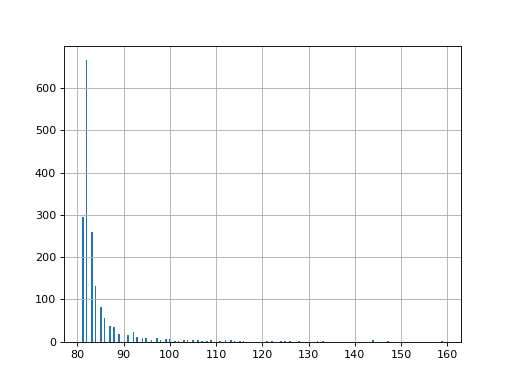

<AxesSubplot:>

In [60]:
plt.figure()
data[(data['tofpet_id']==0)& (data['channel_id']==5) & (data['intg_w']>75) ]['intg_w'].hist(bins=200)

# APPLY TDC CORRECTION

In [61]:
data = bd.apply_tdc_correction(data,coeffs_tdc)

# DATA SELECTION

In [62]:
window_l = 80
window_u = 130
#data_sample = data_e[(data_e['channel_id']==ch) & (data_e['tac_id']==tc) 
#                     & (data_e['integ_w'] >= window_l) & (data_e['integ_w'] < window_u) ]
data_sample = data[(data['intg_w'] >= window_l) & (data['intg_w'] < window_u) ]
#data_sample = data

# APPLY QDC CORRECTION

In [63]:
start_time = time.time()

data_0 = bd.apply_qdc_poly_correction(data_sample[data_sample['tofpet_id']==0],coeffs_qdc)
data_2 = bd.apply_qdc_spl_correction(data_sample[data_sample['tofpet_id']==2],coeffs_qdc)
data_sample = data_0.append(data_2).reset_index()

#data_sample = bd.apply_qdc_p_correction(data_sample,coeffs_qdc)
print("It took %f seconds" % (time.time()-start_time))

It took 6.800657 seconds


<IPython.core.display.Javascript object>


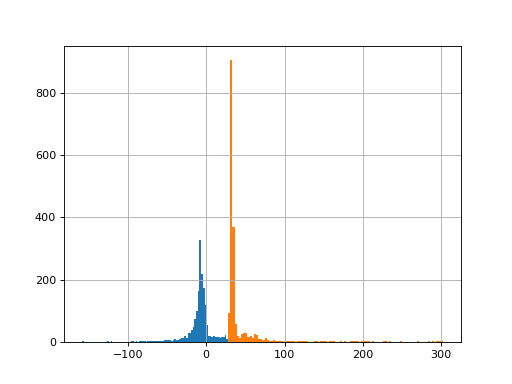

<AxesSubplot:>

In [77]:
plt.figure()
data_sample[(data_sample['tofpet_id']==0) & (data_sample['channel_id']==5) 
            & (data_sample['intg_w'] > 80) & (data_sample['intg_w'] < 140)
            ]['efine_corrected'].hist(bins=100)

data_sample[(data_sample['tofpet_id']==0) & (data_sample['channel_id']==5) 
            & (data_sample['intg_w'] > 80) & (data_sample['intg_w'] < 140) 
            ]['efine'].hist(bins=100)


<IPython.core.display.Javascript object>


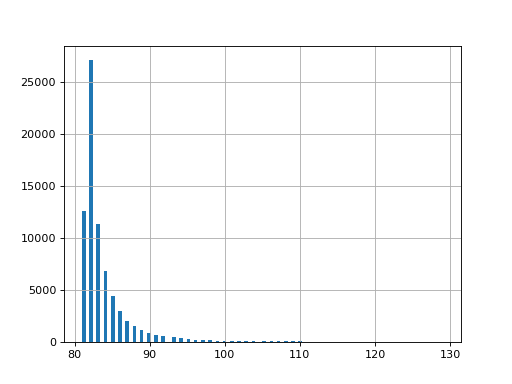

<AxesSubplot:>

In [78]:
plt.figure()
data_sample[data_sample['efine_corrected']<0]['intg_w'].hist(bins=100)

<IPython.core.display.Javascript object>


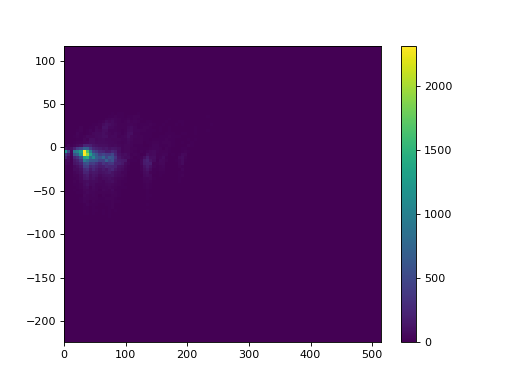

In [65]:
plt.figure()
x=data_sample[(data_sample['tofpet_id']==0) ]['efine']
y=data_sample[(data_sample['tofpet_id']==0) ]['efine_corrected']
plt.hist2d(x,y,bins=100)
plt.colorbar()

In [42]:
data_sample[(data_sample['tofpet_id']==0) & (data_sample['channel_id']==5) 
            & (data_sample['intg_w'] > 76) & (data_sample['intg_w'] < 80)
            & (data_sample['efine_corrected'] < 0)][['intg_w','efine','efine_corrected','tcoarse','ecoarse']]

,intg_w,efine,efine_corrected,tcoarse,ecoarse
50,77,215,-6.852629,55909,690
105,77,209,-11.251672,63579,168
119,77,214,-3.92535,65219,784
149,77,211,-6.92535,2859,888
170,77,213,-8.852629,4600,581
...,...,...,...,...,...
82415,77,212,-9.315071,17113,806
82450,77,207,-13.251672,21067,664
82454,77,210,-7.92535,22801,350
82530,77,205,-12.92535,26342,819


In [ ]:
plt.figure()
x=data_sample[(data_sample['tofpet_id']==0) ]['intg_w']
y=data_sample[(data_sample['tofpet_id']==0) ]['efine_corrected']
plt.hist2d(x,y,bins=100)

# COMPUTE TCOARSE_EXTENDED

In [ ]:
data_sample['tcoarse']      = data_sample.tcoarse.astype(np.int32)
data_sample['tcoarse_diff'] = data_sample.tcoarse.diff()
data_sample['nloops']       = bd.compute_tcoarse_nloops_per_event(data_sample)
data_sample['tcoarse_extended'] = bd.compute_extended_tcoarse(data_sample)
data_sample.drop(columns=['tcoarse_diff','nloops'], inplace=True)

# FIND CLUSTERS

In [ ]:
bd.compute_evt_number_combined_with_cluster_id(data_sample)
nuniq = data_sample.groupby(['cluster'])['sensor_id'].nunique().rename('n_sipms')
clustered_df = data_sample.join(nuniq, on='cluster')

In [ ]:
plt.figure()
clustered_df[clustered_df['tofpet_id']==0]['efine_corrected'].hist(bins=100)

# Event processing

In [ ]:
energy_array_h = []
energy_array_f = []
sipm_array   = []

for i in clustered_df['cluster'].unique():
    if i != -1:
        evt = clustered_df[clustered_df['cluster']==i]
        #print(evt['tofpet_id'].unique())
        
        #Rough coincidence filter
        if evt['tofpet_id'].unique().size == 2:
            hamamatsu = evt[evt['tofpet_id']==0]
            fbk       = evt[evt['tofpet_id']==2]
            energy_hamamatsu = np.sum(hamamatsu['efine_corrected'])
            energy_fbk       = np.sum(fbk['efine_corrected'])
            energy_array_h.append(energy_hamamatsu)
            energy_array_f.append(energy_fbk)
            #sipm_array.append(evt['n_sipms'].unique()[0])
energy_array_h = np.array(energy_array_h)
energy_array_f = np.array(energy_array_f)

In [ ]:
fig = plt.figure(figsize=[10,5])

#energy_array = energy_array[(energy_array>-100) & (energy_array<300)]


axis = fig.add_subplot(121)
coeff,coeff_err,chisq_r=TPcal.gauss_fit(energy_array_h,150,True,axis,'Gauss Fit','','',[0.65,0.5,"left"])

axis2 = fig.add_subplot(122)
coeff,coeff_err,chisq_r=TPcal.gauss_fit(energy_array_f,150,True,axis2,'Gauss Fit','','',[0.65,0.5,"left"])



In [ ]:
clustered_df

In [ ]:

data_sample['intg_w']=data_sample['intg_w'].astype('int')
data_sample['efine_corrected']=data_sample['efine_corrected'].astype('int')

with pd.HDFStore('HIGH_GAIN_qdc.h5','w',complib="zlib",complevel=4) as storage:
    storage.put('data',data_sample,index=False,format='table',data_columns=True)
    storage.close()

# EVENT PLOT (OLD)

In [ ]:
def plot_SiPM(data,key):
    matrix = np.zeros((8,8))
    key_a = np.array(key)
    for line in data.index:
        #print(line)
        sipm  = key_a[data.iloc[line]['channel_id']]
        efine = data.iloc[line]['efine']
        matrix[int(sipm / 10)-1,int(sipm % 10)-1] = efine
    return matrix

In [ ]:
FBK_key_mat = {'ch6': 12,'ch8': 22,'ch10':41,'ch12':23,'ch14':32,
               'ch15':14,'ch16':31,'ch18':33,'ch19':24,'ch20':42,
               'ch22':21,'ch25':34,'ch26':11,'ch28':13,'ch30':43,'ch31':44} 

In [ ]:
HAMA_VUV=[15,46,16,26,25,45,32,35,31,36,22,18,13,17,42,33,21,28,24,34,41,37,12,38,27,43,11,47,14,48,23,44,84,51,81,55,83,52,71,56,54,61,74,65,75,66,53,62,73,76,82,72,64,57,63,86,77,68,87,85,88,58,78,67]
FBK     =[ 0, 0, 0, 0, 0, 0,12, 0,22, 0,41, 0,23, 0,32,14,31, 0,33,24,42, 0,21, 0, 0,34,11, 0,13, 0,43,44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
event_0=pd.DataFrame(np.array([[16,213],[10,257],[20,320],[14,458],[15,461],[22,512],[30,449],[19,487],
                            [26,507],[28,497],[18,496],[8,574],[31,587],[25,608],[12,646]]),columns=['channel_id','efine'])

In [ ]:
light_matrix = plot_SiPM(event_0,FBK)
plt.matshow(light_matrix)
plt.colorbar()

In [ ]:
HAMA_VUV_a = np.array(HAMA_VUV)
HAMA_VUV_a[[6,8,9,10,12,14,15,16,20,22,24,26,28,30,38]]

In [ ]:
res = []
for i in range(1,5):
    for j in range(1,5):
        res.append(np.argwhere(HAMA_VUV_a==i*10+j)[0][0])
        

In [ ]:
res

In [ ]:
HAMA_VUV[24]

In [ ]:
HAMA_VUV[15]

In [ ]:
HAMA_VUV[28]

In [ ]:
HAMA_VUV[30]

In [ ]:
HAMA_VUV[38]